<a href="https://colab.research.google.com/github/gzholtkevych/covid-19/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx

In [2]:
# Building the disease model graph
dmg = nx.DiGraph()
dmg.add_nodes_from("SECIRD")
dmg.add_edges_from([('S', 'E'), ('E', 'C'), ('E', 'I'), ('C', 'I'), ('C', 'R'), ('I', 'R'), ('I', 'D'), ('S', 'R')])

Here, the following notation is used:

* $S$ refers to the phase, during which there are no contacts with individuals being in phases $C$ or $I$
* $E$ refers to the phase risen immediately after contact with an individual being in phase $C$ or in phase $I$
* $C$ refers to the phase characterised by that an individual being in the phase is a source of infection spreading without any disease symptoms
* $I$ refers to the phase of the symptomatic phase of the disease
* $R$ refers to the phase, the recovered patients inhabit which
* $D$ means the patient's death

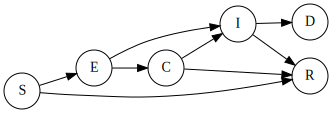

In [3]:
# Visualization the isease model graph
from graphviz import Digraph

covid19_statechart = Digraph("Statechart COVID-19 Model")
covid19_statechart.attr(rankdir='LR', size='8,8', minlen='5')

for n in dmg.nodes:
    covid19_statechart.node(n, n, shape='circle')
for e in dmg.edges:
    t, h = e
    covid19_statechart.edge(t, h)
covid19_statechart

In [4]:
# Setting transition probabilities for edges of the disease model graph
dmg.edges['S', 'E']['pr_t'] = 0.05
dmg.edges['S', 'R']['pr_t'] = 0.0
dmg.edges['E', 'C']['pr_t'] = 0.6
dmg.edges['E', 'I']['pr_t'] = 0.3
dmg.edges['C', 'I']['pr_t'] = 0.6
dmg.edges['C', 'R']['pr_t'] = 0.2
dmg.edges['I', 'D']['pr_t'] = 0.02
dmg.edges['I', 'R']['pr_t'] = 0.98

In [5]:
# Simulation
from numpy.random import choice

# initializing population
population_size = 1000
population = [dict(id=i, phase='S') for i in range(population_size)]

iteration_num = 300  # defining simulation period
report = []
for day in range(iteration_num):
    # spreading
    for i in population:
        cphase = i['phase']
        tgs = [(phase, dmg[cphase][phase]['pr_t']) for phase in dmg[cphase]]
        pstay = 1 - sum([itm[1] for itm in tgs])
        if pstay > 0:
            tgs.append((cphase, pstay))
        i['phase'] = choice([itm[0] for itm in tgs],
                             p=[itm[1] for itm in tgs])
    # reporting
    report_item = dict()
    for phase in "SECIRD":
        report_item[phase] = len([i for i in population if
                                  i['phase'] == phase]) / population_size
    report.append(report_item)

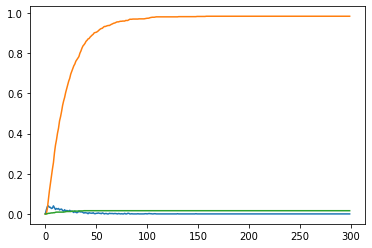

In [6]:
# Visualization
import matplotlib.pyplot as plt

days = list(range(iteration_num))
Is = [report_item['I'] for report_item in report]
Rs = [report_item['R'] for report_item in report]
Ds = [report_item['D'] for report_item in report]
plt.plot(days, Is, days, Rs, days, Ds)